# Applied Data Science Capstone Week 5


## Introduction/Business Problem

I have been living in Manhattan for more than seven years. As a result of Covid-19 restrictions, a lot of my beloved restaurant/bakery/Café are permanently closed. 

On Wednesday, June 9, 2021, New York Gov. Andrew Cuomo speaks at the opening ceremony of the Tribeca Film Festival. With 70% vaccinated, New York State is reopening from most Covid-19 restrictions.

I would like to use Foursquare location data to see which area in Manhattan has best potential to open a new Chinese restaurant.


In [92]:
from IPython.display import Image
Image(url= "60c172a78cd90.image.jpg",  width=800, height=800)

## Data section

Even though this course already have detailed guide for getting New York City Data, we'd like to use latest 2021 data obtained from www.propertyshark.com for two main reasons:
1. Up-to-date Neighborhood, focused for Manhattan
2. Real Estate Median Sale Price could be a indicator of neighborhood buying power

url = "https://www.propertyshark.com/mason/market-trends/residential/nyc/manhattan"

#### Import Libraries 

In [93]:
import numpy as np # library to handle data in a vectorized manner

import pandas as pd # library for data analsysis
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)

import json # library to handle JSON files

#!conda install -c conda-forge geopy --yes # uncomment this line if you haven't completed the Foursquare API lab
from geopy.geocoders import Nominatim # convert an address into latitude and longitude values

import requests # library to handle requests
from pandas.io.json import json_normalize # tranform JSON file into a pandas dataframe

# Matplotlib and associated plotting modules
import matplotlib.cm as cm
import matplotlib.colors as colors

# import k-means from clustering stage
from sklearn.cluster import KMeans

#!conda install -c conda-forge folium=0.5.0 --yes # uncomment this line if you haven't completed the Foursquare API lab
import folium # map rendering library

print('Libraries imported.')

Libraries imported.


#### Define Foursquare Credentials and Version

In [94]:
CLIENT_ID = 'ICXVSITQ5UMI32QUFD1ZE0AMTFLK3ATJAB5EUB53IA3IR0XT' # your Foursquare ID
CLIENT_SECRET = 'ISWXCRS4QH3XWZQ15I0K4YVE4CIWESN5LSCYH5Q20UOL0KUC' # your Foursquare Secret
ACCESS_TOKEN = 'XQ2NBDFQXW2A5S5KOFNPUPTZ1Z43YWHDW5JRK5NMJMWZW04D' # your FourSquare Access Token
VERSION = '20210620' # current date
LIMIT = 100 # A default Foursquare API limit value

print('Your credentails:')
print('CLIENT_ID: ' + CLIENT_ID)
print('CLIENT_SECRET:' + CLIENT_SECRET)

Your credentails:
CLIENT_ID: ICXVSITQ5UMI32QUFD1ZE0AMTFLK3ATJAB5EUB53IA3IR0XT
CLIENT_SECRET:ISWXCRS4QH3XWZQ15I0K4YVE4CIWESN5LSCYH5Q20UOL0KUC


#### Get Manhattan Neighborhood Data

In [95]:
# load propertyshark neighborhoods data
propertyshark_data = pd.read_csv('manhattan_real_estate.csv')
propertyshark_data.head()

,Neighborhood,Borough,Median Sale Price
0,Battery Park City,Manhattan,762900.0
1,Carnegie Hill,Manhattan,1500000.0
2,Central Midtown,Manhattan,830000.0
3,Central Park South,Manhattan,2147500.0
4,Chelsea,Manhattan,1077600.0


#### Get Manhattan Neighborhood Data

In [96]:
# define the dataframe columns
column_names = ['Borough', 'Neighborhood', 'Latitude', 'Longitude', 'Meidian Sale Price'] 
geolocator = Nominatim(user_agent="foursquare_agent")

# instantiate the dataframe
manhattan_data = pd.DataFrame(columns=column_names)

for index, row in propertyshark_data.iterrows():
    address = row.Neighborhood + ', ' + row.Borough
    location = geolocator.geocode(address)
    latitude = location.latitude
    longitude = location.longitude
    
    manhattan_data = manhattan_data.append({'Borough': row.Borough,
                                          'Neighborhood': row.Neighborhood,
                                          'Latitude': latitude,
                                          'Longitude': longitude,
                                          'Meidian Sale Price': row[-1]}, ignore_index=True)
manhattan_data.head()

,Borough,Neighborhood,Latitude,Longitude,Meidian Sale Price
0,Manhattan,Battery Park City,40.711017,-74.016937,762900.0
1,Manhattan,Carnegie Hill,40.784197,-73.954339,1500000.0
2,Manhattan,Central Midtown,40.756182,-73.981039,830000.0
3,Manhattan,Central Park South,40.767814,-73.981232,2147500.0
4,Manhattan,Chelsea,40.746491,-74.001528,1077600.0


#### Get restaurant raw data

In [97]:
def getNearbyRestaurant(names, latitudes, longitudes, radius=800, search_query = 'Restaurant'):
    
    venues_list=[]
    for name, lat, lng in zip(names, latitudes, longitudes):
        print(name)
        
        # create the API request URL
        url = 'https://api.foursquare.com/v2/venues/search?client_id={}&client_secret={}&ll={},{}&oauth_token={}&v={}&query={}&radius={}&limit={}'.format(
            CLIENT_ID, CLIENT_SECRET, lat, lng, ACCESS_TOKEN, VERSION, search_query, radius, LIMIT)
            
        # make the GET request
        results = requests.get(url).json()['response']['venues']
        df = json_normalize(results)
        for index, row in df.iterrows():
            if row['categories']==[]:
                df.drop(index, inplace=True)
        df.reset_index(drop=True)
        
        # return only relevant information for each nearby venue
        venues_list.append([(
            name, 
            lat, 
            lng, 
            row['name'], 
            row['location.lat'], 
            row['location.lng'],  
            row['categories'][0]['name']) for index, row in df.iterrows()])

    nearby_venues = pd.DataFrame([item for venue_list in venues_list for item in venue_list])
    nearby_venues.columns = ['Neighborhood', 
                  'Neighborhood Latitude', 
                  'Neighborhood Longitude', 
                  'Venue', 
                  'Venue Latitude', 
                  'Venue Longitude', 
                  'Venue Category']
    
    return(nearby_venues)

In [98]:
manhattan_restaurant = getNearbyRestaurant(names=manhattan_data['Neighborhood'],
                                   latitudes=manhattan_data['Latitude'],
                                   longitudes=manhattan_data['Longitude']
                                  )

Battery Park City


/home/jupyterlab/conda/envs/python/lib/python3.6/site-packages/ipykernel_launcher.py:13: FutureWarning: pandas.io.json.json_normalize is deprecated, use pandas.json_normalize instead
  del sys.path[0]


Carnegie Hill
Central Midtown
Central Park South
Chelsea
Chinatown
Civic Center
Clinton - Hell's Kitchen
East Harlem
East Village
Financial District
Flatiron District
Garment District
Gramercy Park
Greenwich Village
Harlem
Hudson Square
Hudson Yards
Inwood
Kips Bay
Koreatown
Lenox Hill
Lincoln Square
Little Italy
Lower East Side
Manhattan Valley
Morningside Heights
Murray Hill
NoHo
NoLIta
NoMad
Roosevelt Island
SoHo
Sutton Place
Theatre District - Times Square
TriBeCa
Tudor City
Turtle Bay
Two Bridges
Upper West Side
Washington Heights
West Village
Yorkville


In [99]:
print('There are {} uniques categories.'.format(len(manhattan_restaurant['Venue Category'].unique())))
manhattan_restaurant['Venue Category'].unique()

There are 120 uniques categories.


array(['Pub', 'Wings Joint', 'Pizza Place', 'Chinese Restaurant',
       'Lounge', 'Seafood Restaurant', 'Food Court', 'Restaurant',
       'New American Restaurant', 'American Restaurant',
       'Italian Restaurant', 'Food', 'Sandwich Place', 'Non-Profit',
       'Office', 'Caribbean Restaurant', 'Korean Restaurant', 'Dive Bar',
       'Mexican Restaurant', 'Diner', 'Steakhouse', 'Indian Restaurant',
       'German Restaurant', 'Indian Chinese Restaurant',
       'Latin American Restaurant', 'Asian Restaurant', 'Coffee Shop',
       'Neighborhood', 'Thai Restaurant', 'Japanese Restaurant',
       'French Restaurant', 'Hospital', 'Café', 'Sushi Restaurant',
       'Bakery', 'Irish Pub', 'Bar', 'Hotpot Restaurant',
       'Conference Room', 'Vietnamese Restaurant', 'Hawaiian Restaurant',
       'Other Great Outdoors', 'Cocktail Bar', 'Brazilian Restaurant',
       'Event Space', 'Szechuan Restaurant', 'Turkish Restaurant',
       'Tea Room', 'Art Museum', 'Mediterranean Restaurant',
  

#### Data Cleaning

There are some problems regarding foursquare api data
1. Some result is not restaurant, we need drop them
2. Chinese restaurants are labeled as specific type restaurant, like “Szechuan Restaurant”, we need combine them together.
3. Additionally, I need label other Asian restaurant as potential competitors.

In [100]:
for index, row in manhattan_restaurant.iterrows():
    if row['Venue Category'] in ('Miscellaneous Shop',
                                 'Business Service',
                                 'Beer Garden',
                                 'Metro Station',
                                 'Music Venue',
                                 'Neighborhood',
                                 'Hotel',
                                 'Gift Shop',
                                 'Brewery',
                                 'Sports Bar',
                                 'Salon / Barbershop',
                                 'Office',
                                 'Art Museum',
                                 'Event Space',
                                 'Other Great Outdoors',
                                 'Conference Room',
                                 'Theater',
                                 'Building',
                                 'Plaza',
                                 'Gastropub',
                                 'Tech Startup',
                                 'Kitchen Supply Store',
                                 'Art Gallery',
                                 'Arts & Crafts Store',
                                 'Department Store',
                                 'Housing Development',
                                 'Garden',
                                 'Home Service',
                                 'Candy Store'
                                 'Furniture / Home Store',
                                 'Non-Profit',
                                 'Hardware Store',
                                 'Shopping Mall',
                                 'Coworking Space',
                                 'Other Nightlife'):
        manhattan_restaurant.drop(index, inplace=True)
        manhattan_restaurant.reset_index(drop=True)

In [101]:
manhattan_restaurant['New Category'] = ''
for index, row in manhattan_restaurant.iterrows():
    if row['Venue Category'] in ('Chinese Restaurant',
                                 'Dim Sum Restaurant',
                                 'Cantonese Restaurant',
                                 'Noodle House',
                                 'Dumpling Restaurant',
                                 'Indian Chinese Restaurant',
                                 'Hotpot Restaurant',
                                 'Szechuan Restaurant',
                                 'Fujian Restaurant'):
        manhattan_restaurant.loc[index, 'New Category'] = 'Chinese Restaurant'
    elif row['Venue Category'] in ('Thai Restaurant',
                                   'Soba Restaurant',
                                   'Korean Restaurant',
                                   'Japanese Restaurant',
                                   'Sushi Restaurant',
                                   'Vietnamese Restaurant',
                                   'Ramen Restaurant',
                                   'Asian Restaurant'):
        manhattan_restaurant.loc[index, 'New Category'] = 'Alternative'
    else:
        manhattan_restaurant.loc[index, 'New Category'] = 'Other'
    

manhattan_restaurant.head()

,Neighborhood,Neighborhood Latitude,Neighborhood Longitude,Venue,Venue Latitude,Venue Longitude,Venue Category,New Category
0,Battery Park City,40.711017,-74.016937,O'Hara's Restaurant & Pub,40.709894,-74.012836,Pub,Other
1,Battery Park City,40.711017,-74.016937,Mudville Restaurant & Tap House,40.715209,-74.008923,Wings Joint,Other
2,Battery Park City,40.711017,-74.016937,Amore's Pizza Restaurant,40.715860,-74.009888,Pizza Place,Other
3,Battery Park City,40.711017,-74.016937,Yips Restaurant,40.704950,-74.012360,Chinese Restaurant,Chinese Restaurant
4,Battery Park City,40.711017,-74.016937,Su Hang Restaurant,40.708363,-74.014046,Chinese Restaurant,Chinese Restaurant


#### Grouping and Final Table Construction

In [102]:
# one hot encoding
manhattan_onehot = pd.get_dummies(manhattan_restaurant[['New Category']], prefix="", prefix_sep="")

# add neighborhood column back to dataframe
manhattan_onehot['Neighborhood'] = manhattan_restaurant['Neighborhood'] 

# move neighborhood column to the first column
fixed_columns = [manhattan_onehot.columns[-1]] + list(manhattan_onehot.columns[:-1])
manhattan_onehot = manhattan_onehot[fixed_columns]
manhattan_grouped = manhattan_onehot.groupby('Neighborhood').mean().reset_index()
manhattan_grouped.head()

,Neighborhood,Alternative,Chinese Restaurant,Other
0,Battery Park City,0.022727,0.113636,0.863636
1,Carnegie Hill,0.148936,0.042553,0.808511
2,Central Midtown,0.069767,0.046512,0.883721
3,Central Park South,0.065217,0.043478,0.891304
4,Chelsea,0.097561,0.146341,0.756098


In [103]:
restaurant_count = manhattan_restaurant.groupby('Neighborhood').count()
restaurant_count = restaurant_count.Venue.to_frame()
restaurant_count.head()

,Venue
Neighborhood,
Battery Park City,44
Carnegie Hill,47
Central Midtown,43
Central Park South,46
Chelsea,41


In [104]:
temp1 = manhattan_data.merge(restaurant_count, how='inner', on='Neighborhood')
final_data = temp1.merge(manhattan_grouped, how='inner', on='Neighborhood')
final_data

,Borough,Neighborhood,Latitude,Longitude,Meidian Sale Price,Venue,Alternative,Chinese Restaurant,Other
0,Manhattan,Battery Park City,40.711017,-74.016937,762900.0,44,0.022727,0.113636,0.863636
1,Manhattan,Carnegie Hill,40.784197,-73.954339,1500000.0,47,0.148936,0.042553,0.808511
2,Manhattan,Central Midtown,40.756182,-73.981039,830000.0,43,0.069767,0.046512,0.883721
3,Manhattan,Central Park South,40.767814,-73.981232,2147500.0,46,0.065217,0.043478,0.891304
4,Manhattan,Chelsea,40.746491,-74.001528,1077600.0,41,0.097561,0.146341,0.756098
5,Manhattan,Chinatown,40.716491,-73.996250,1733179.0,44,0.068182,0.636364,0.295455
6,Manhattan,Civic Center,40.713679,-74.002404,2760000.0,48,0.062500,0.583333,0.354167
7,Manhattan,Clinton - Hell's Kitchen,40.768228,-73.994269,779500.0,50,0.080000,0.000000,0.920000
8,Manhattan,East Harlem,40.794722,-73.942500,790000.0,48,0.000000,0.166667,0.833333
9,Manhattan,East Village,40.729269,-73.987361,1049500.0,40,0.125000,0.025000,0.850000


## Methodology section

#### Visualizing Data using Matplotlib

In [105]:
%matplotlib inline
import matplotlib as mpl
import matplotlib.pyplot as plt

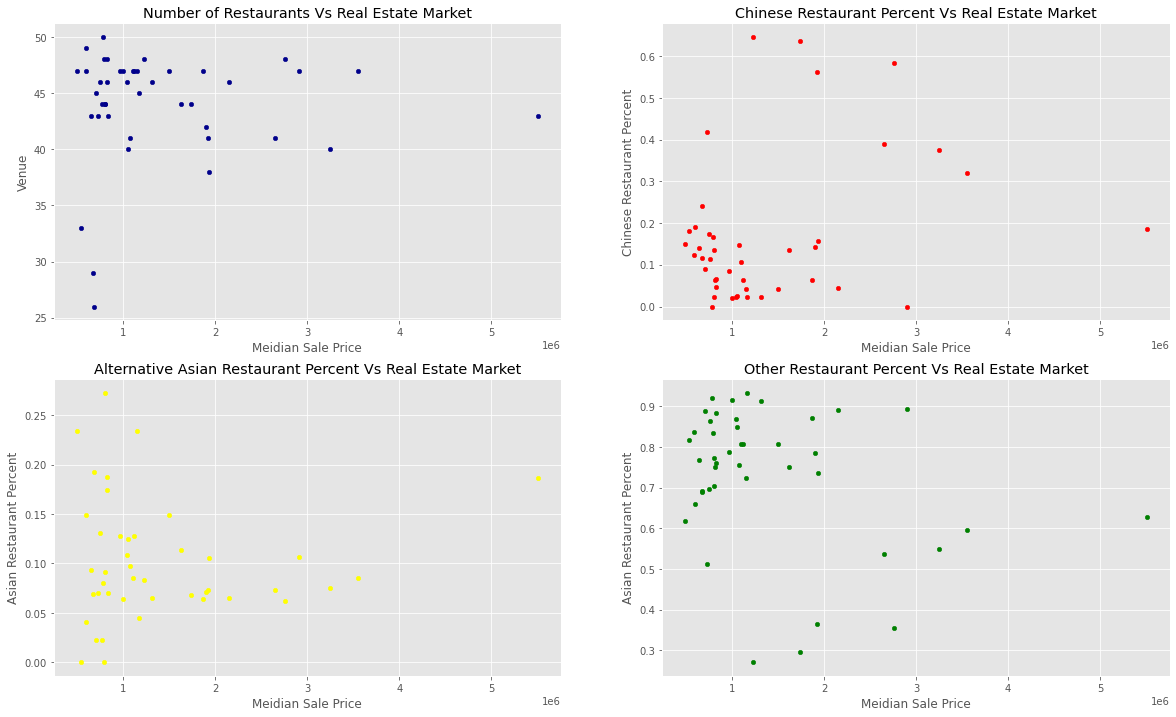

In [106]:
fig = plt.figure() # create figure

ax0 = fig.add_subplot(2, 2, 1) 
ax1 = fig.add_subplot(2, 2, 2) 
ax2 = fig.add_subplot(2, 2, 3) 
ax3 = fig.add_subplot(2, 2, 4) 

# Subplot 1
final_data.plot(kind='scatter', x='Meidian Sale Price', y='Venue', figsize=(20, 12), color='darkblue', ax=ax0)
ax0.set_title('Number of Restaurants Vs Real Estate Market')
ax0.set_xlabel('Meidian Sale Price')
ax0.set_ylabel('Venue')

# Subplot 2
final_data.plot(kind='scatter', x='Meidian Sale Price', y='Chinese Restaurant', figsize=(20, 12), color='red', ax=ax1) # add to subplot 1
ax1.set_title('Chinese Restaurant Percent Vs Real Estate Market')
ax1.set_xlabel('Meidian Sale Price')
ax1.set_ylabel('Chinese Restaurant Percent')

# Subplot 3
final_data.plot(kind='scatter', x='Meidian Sale Price', y='Alternative', figsize=(20, 12), color='yellow', ax=ax2) # add to subplot 1
ax2.set_title('Alternative Asian Restaurant Percent Vs Real Estate Market')
ax2.set_xlabel('Meidian Sale Price')
ax2.set_ylabel('Asian Restaurant Percent')

# Subplot 4
final_data.plot(kind='scatter', x='Meidian Sale Price', y='Other', figsize=(20, 12), color='green', ax=ax3) # add to subplot 1
ax3.set_title('Other Restaurant Percent Vs Real Estate Market')
ax3.set_xlabel('Meidian Sale Price')
ax3.set_ylabel('Asian Restaurant Percent')

plt.show()

#### Select Rich Neighborhood with low Chinese restaurant rate

In [107]:
final_data[(final_data['Meidian Sale Price'] > 2000000) & (final_data['Chinese Restaurant'] < 0.05)]

,Borough,Neighborhood,Latitude,Longitude,Meidian Sale Price,Venue,Alternative,Chinese Restaurant,Other
3,Manhattan,Central Park South,40.767814,-73.981232,2147500.0,46,0.065217,0.043478,0.891304
16,Manhattan,Hudson Square,40.726804,-74.007983,2906012.0,47,0.106383,0.000000,0.893617


#### Clustering

In [108]:
# set number of clusters
kclusters = 5

grouped_clustering = final_data.drop(['Borough', 'Neighborhood','Venue','Other'], axis=1)

# run k-means clustering
kmeans = KMeans(n_clusters=kclusters, random_state=0).fit(grouped_clustering)

# check cluster labels generated for each row in the dataframe
final_data.insert(0, 'Cluster Labels', kmeans.labels_)
final_data.head(10)

,Cluster Labels,Borough,Neighborhood,Latitude,Longitude,Meidian Sale Price,Venue,Alternative,Chinese Restaurant,Other
0,4,Manhattan,Battery Park City,40.711017,-74.016937,762900.0,44,0.022727,0.113636,0.863636
1,3,Manhattan,Carnegie Hill,40.784197,-73.954339,1500000.0,47,0.148936,0.042553,0.808511
2,4,Manhattan,Central Midtown,40.756182,-73.981039,830000.0,43,0.069767,0.046512,0.883721
3,3,Manhattan,Central Park South,40.767814,-73.981232,2147500.0,46,0.065217,0.043478,0.891304
4,1,Manhattan,Chelsea,40.746491,-74.001528,1077600.0,41,0.097561,0.146341,0.756098
5,3,Manhattan,Chinatown,40.716491,-73.996250,1733179.0,44,0.068182,0.636364,0.295455
6,0,Manhattan,Civic Center,40.713679,-74.002404,2760000.0,48,0.062500,0.583333,0.354167
7,4,Manhattan,Clinton - Hell's Kitchen,40.768228,-73.994269,779500.0,50,0.080000,0.000000,0.920000
8,4,Manhattan,East Harlem,40.794722,-73.942500,790000.0,48,0.000000,0.166667,0.833333
9,1,Manhattan,East Village,40.729269,-73.987361,1049500.0,40,0.125000,0.025000,0.850000


In [109]:
# create map
map_clusters = folium.Map(location=[latitude, longitude], zoom_start=11)

# set color scheme for the clusters
x = np.arange(kclusters)
ys = [i + x + (i*x)**2 for i in range(kclusters)]
colors_array = cm.rainbow(np.linspace(0, 1, len(ys)))
rainbow = [colors.rgb2hex(i) for i in colors_array]

# add markers to the map
markers_colors = []
for lat, lon, poi, cluster in zip(final_data['Latitude'], final_data['Longitude'], final_data['Neighborhood'], final_data['Cluster Labels']):
    label = folium.Popup(str(poi) + ' Cluster ' + str(cluster), parse_html=True)
    folium.CircleMarker(
        [lat, lon],
        radius=5,
        popup=label,
        color=rainbow[cluster-1],
        fill=True,
        fill_color=rainbow[cluster-1],
        fill_opacity=0.7).add_to(map_clusters)
       
map_clusters

In [110]:
final_data.loc[final_data['Cluster Labels'] == 0]

,Cluster Labels,Borough,Neighborhood,Latitude,Longitude,Meidian Sale Price,Venue,Alternative,Chinese Restaurant,Other
6,0,Manhattan,Civic Center,40.713679,-74.002404,2760000.0,48,0.062500,0.583333,0.354167
16,0,Manhattan,Hudson Square,40.726804,-74.007983,2906012.0,47,0.106383,0.000000,0.893617
29,0,Manhattan,NoLIta,40.722989,-73.994558,2647450.0,41,0.073171,0.390244,0.536585
32,0,Manhattan,SoHo,40.722880,-73.998750,3250000.0,40,0.075000,0.375000,0.550000
35,0,Manhattan,TriBeCa,40.715380,-74.009306,3550000.0,47,0.085106,0.319149,0.595745


In [111]:
final_data.loc[final_data['Cluster Labels'] == 1]

,Cluster Labels,Borough,Neighborhood,Latitude,Longitude,Meidian Sale Price,Venue,Alternative,Chinese Restaurant,Other
4,1,Manhattan,Chelsea,40.746491,-74.001528,1077600.0,41,0.097561,0.146341,0.756098
9,1,Manhattan,East Village,40.729269,-73.987361,1049500.0,40,0.125000,0.025000,0.850000
10,1,Manhattan,Financial District,40.707668,-74.009271,967500.0,47,0.127660,0.085106,0.787234
13,1,Manhattan,Gramercy Park,40.737939,-73.985922,1119375.0,47,0.127660,0.063830,0.808511
14,1,Manhattan,Greenwich Village,40.733584,-74.002817,1165000.0,45,0.044444,0.022222,0.933333
21,1,Manhattan,Lenox Hill,40.766437,-73.959017,1150000.0,47,0.234043,0.042553,0.723404
22,1,Manhattan,Lincoln Square,40.772319,-73.984401,1040000.0,46,0.108696,0.021739,0.869565
34,1,Manhattan,Theatre District - Times Square,40.763398,-73.983355,997500.0,47,0.063830,0.021277,0.914894
38,1,Manhattan,Two Bridges,40.711288,-73.992233,1225900.0,48,0.083333,0.645833,0.270833
39,1,Manhattan,Upper West Side,40.787045,-73.975416,1100000.0,47,0.085106,0.106383,0.808511


In [112]:
final_data.loc[final_data['Cluster Labels'] == 2]

,Cluster Labels,Borough,Neighborhood,Latitude,Longitude,Meidian Sale Price,Venue,Alternative,Chinese Restaurant,Other
17,2,Manhattan,Hudson Yards,40.755906,-74.000532,5504250.0,43,0.186047,0.186047,0.627907


In [113]:
final_data.loc[final_data['Cluster Labels'] == 3]

,Cluster Labels,Borough,Neighborhood,Latitude,Longitude,Meidian Sale Price,Venue,Alternative,Chinese Restaurant,Other
1,3,Manhattan,Carnegie Hill,40.784197,-73.954339,1500000.0,47,0.148936,0.042553,0.808511
3,3,Manhattan,Central Park South,40.767814,-73.981232,2147500.0,46,0.065217,0.043478,0.891304
5,3,Manhattan,Chinatown,40.716491,-73.996250,1733179.0,44,0.068182,0.636364,0.295455
11,3,Manhattan,Flatiron District,40.741072,-73.989653,1865000.0,47,0.063830,0.063830,0.872340
12,3,Manhattan,Garment District,40.753694,-73.990517,1900000.0,42,0.071429,0.142857,0.785714
23,3,Manhattan,Little Italy,40.719273,-73.998215,1925000.0,41,0.073171,0.560976,0.365854
28,3,Manhattan,NoHo,40.725875,-73.993957,1935000.0,38,0.105263,0.157895,0.736842
30,3,Manhattan,NoMad,40.744688,-73.988285,1623500.0,44,0.113636,0.136364,0.750000


In [114]:
final_data.loc[final_data['Cluster Labels'] == 4]

,Cluster Labels,Borough,Neighborhood,Latitude,Longitude,Meidian Sale Price,Venue,Alternative,Chinese Restaurant,Other
0,4,Manhattan,Battery Park City,40.711017,-74.016937,762900.0,44,0.022727,0.113636,0.863636
2,4,Manhattan,Central Midtown,40.756182,-73.981039,830000.0,43,0.069767,0.046512,0.883721
7,4,Manhattan,Clinton - Hell's Kitchen,40.768228,-73.994269,779500.0,50,0.080000,0.000000,0.920000
8,4,Manhattan,East Harlem,40.794722,-73.942500,790000.0,48,0.000000,0.166667,0.833333
15,4,Manhattan,Harlem,40.807879,-73.945415,705000.0,45,0.022222,0.088889,0.888889
18,4,Manhattan,Inwood,40.869258,-73.920495,535000.0,33,0.000000,0.181818,0.818182
19,4,Manhattan,Kips Bay,40.739546,-73.977083,597000.0,47,0.148936,0.191489,0.659574
20,4,Manhattan,Koreatown,40.747642,-73.986516,645000.0,43,0.093023,0.139535,0.767442
24,4,Manhattan,Lower East Side,40.715936,-73.986806,728000.0,43,0.069767,0.418605,0.511628
25,4,Manhattan,Manhattan Valley,40.799776,-73.967772,800000.0,44,0.090909,0.136364,0.772727
